In [20]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null

In [6]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [7]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/content/64x64/train_normal/train_normal_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/64x64/train_attack/train_attack_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/64x64/test_normal/test_normal_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/64x64/test_attack/test_attack_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [8]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

((1874, 64, 64), (1628, 64, 64), (271, 64, 64), (357, 64, 64))

In [9]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
# rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
# rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
# rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
# rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal))

In [ ]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_attack))
test = np.vstack((test_normal, test_attack))

In [ ]:
train.shape, test.shape

((3502, 64, 64), (628, 64, 64))

In [10]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

In [11]:
train.shape, test.shape

((10506, 64, 64, 1), (1884, 64, 64, 1))

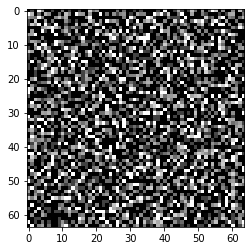

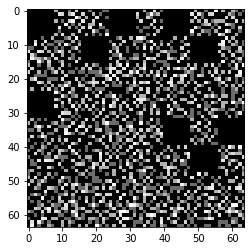

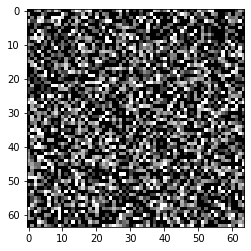

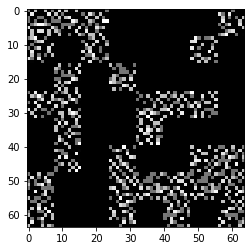

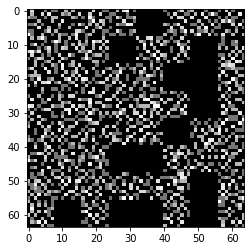

In [12]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [ ]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [13]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [14]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 10501       0       1
 10502       0       1
 10503       0       1
 10504       0       1
 10505       0       1
 
 [10506 rows x 2 columns],       attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 1879       0       1
 1880       0       1
 1881       0       1
 1882       0       1
 1883       0       1
 
 [1884 rows x 2 columns])

In [15]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = None)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = None)

In [21]:
# KERNEL_SIZE = [2,2]
# IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(16, (2,2), padding="same", activation='relu', input_shape = (64,64,1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(32, (2,2), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 3
# cnn.add(Convolution2D(64, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.25))

# ## convolution 4
# cnn.add(Convolution2D(128, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
cnn.add(Dense(12, activation='relu'))
cnn.add(Dense(6, activation='relu'))
cnn.add(Dense(4, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                98316     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [22]:
# start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 128, epochs = 500)
# end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
# print(f'Training finished in {round(end - start, 2)}')

Epoch 1/500
49/83 [================>.............] - ETA: 7s - loss: 1.3206 - accuracy: 0.5391

KeyboardInterrupt: ignored

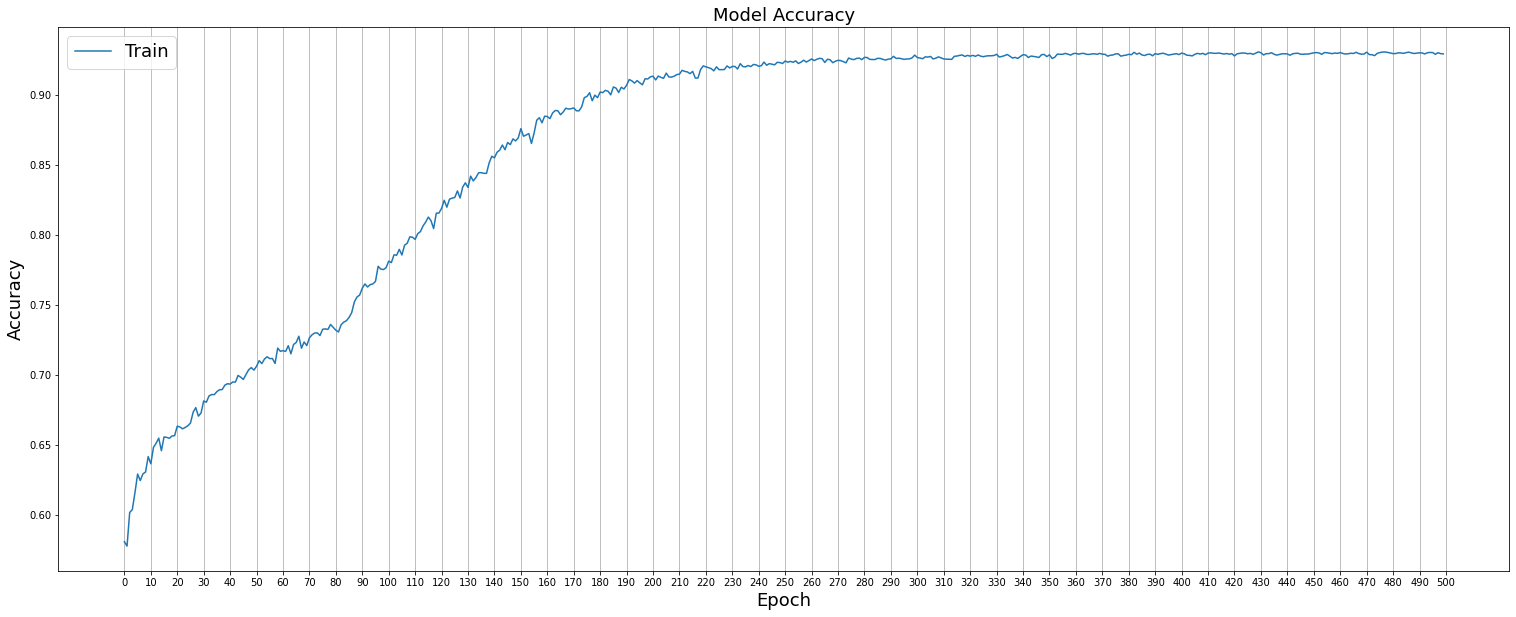

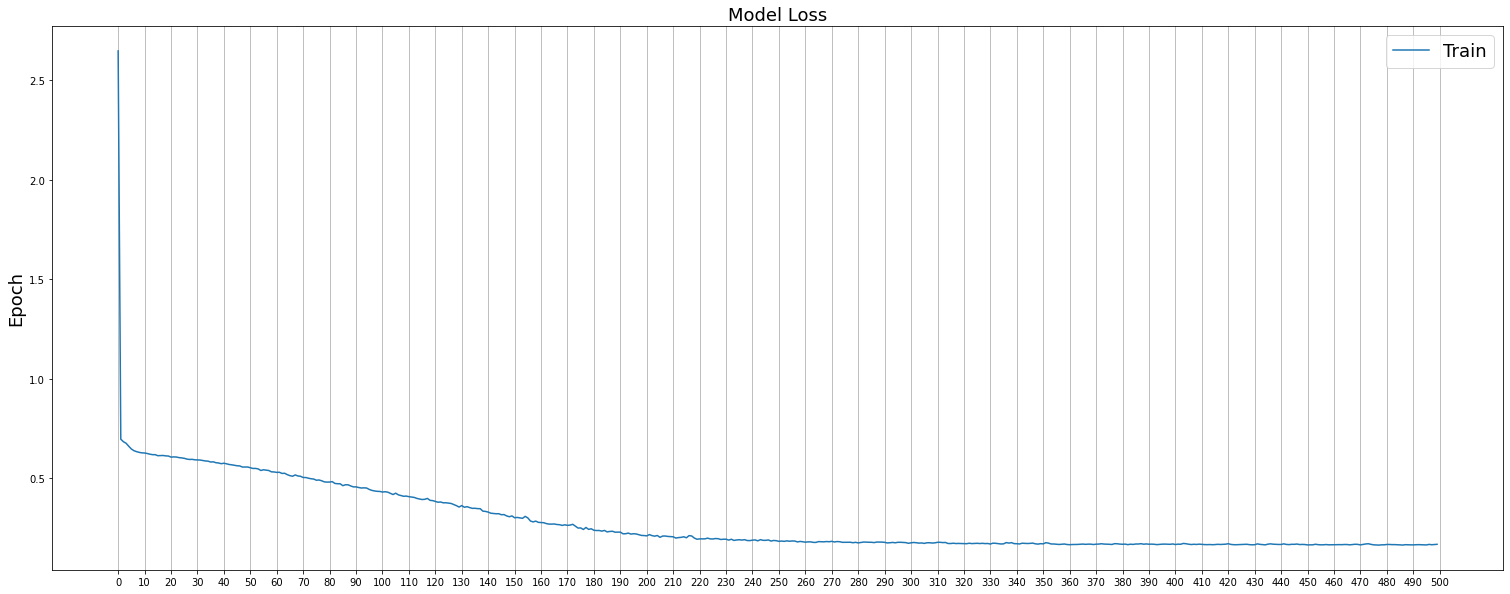

In [ ]:
# print(model_history.history.keys())

figure(figsize = (26,10))
plt.plot(model_history.history['accuracy'])
# plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 510, step = 10))
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

print()

figure(figsize = (26,10))
plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 510, step = 10), )
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

In [ ]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 512, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 4.4697	Accuracy = 56.69%


In [ ]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.1915 , 0.84903],
       [0.00865, 0.98934],
       [0.00017, 0.99988],
       [1.     , 0.     ],
       [0.98275, 0.01635],
       [0.     , 1.     ],
       [0.43259, 0.60568],
       [0.01426, 0.99005],
       [0.04961, 0.95337],
       [0.22527, 0.77467],
       [0.22527, 0.77467],
       [0.0158 , 0.98798],
       [0.     , 1.     ],
       [0.02629, 0.98135],
       [0.     , 1.     ],
       [0.     , 1.     ],
       [0.00126, 0.99929],
       [0.     , 1.     ],
       [0.22527, 0.77467],
       [0.     , 1.     ]], dtype=float32)

In [ ]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (2,2), padding="same", activation='relu', input_shape = (64,64,1)))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (2,2), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (2,2), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (2,2), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adamax(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 512, epochs = 500)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 32ms/step - loss: 0.8648 - accuracy: 0.6462
Epoch 7/500
3/3 [==============================] - 0s 36ms/step - loss: 0.7907 - accuracy: 0.6506
Epoch 8/500
3/3 [==============================] - 0s 32ms/step - loss: 0.7027 - accuracy: 0.6968
Epoch 9/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6719 - accuracy: 0.7066
Epoch 10/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6497 - accuracy: 0.7033
Epoch 11/500
3/3 [==============================] - 0s 33ms/step - loss: 0.6351 - accuracy: 0.7140
Epoch 12/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6338 - accuracy: 0.7006
Epoch 13/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6368 - accuracy: 0.7143
Epoch 14/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6456 - accuracy: 0.7062
Epoch 15/500
3/3 [==============================] - 0s 31ms/step - loss: 0